# Random Explore all nodes of graph -200 for invalid, action move to next node

--- Generating Graph Series ---
Sizes: [20, 30, 40, 50, 60]
Connectivity: 0.25, Busy Node Interval: 5

Creating graph size: 20 (seed=62)...
  Graph created: 20 nodes, 44 edges.

Creating graph size: 30 (seed=72)...
  Graph created: 30 nodes, 106 edges.

Creating graph size: 40 (seed=82)...
  Graph created: 40 nodes, 199 edges.

Creating graph size: 50 (seed=92)...
  Graph created: 50 nodes, 300 edges.

Creating graph size: 60 (seed=102)...
  Graph created: 60 nodes, 416 edges.

--- Graph Generation Complete ---

--- Starting Benchmarking Across Sizes (QL Expanded Action Space) ---

=============== Processing Graph Size: 20 ===============
Initializing Q-Learning agent (Expanded Actions) for size 20...
Training QL for 40000 episodes...

--- Starting QL Training (Expanded Action Space, Size: 20, Episodes: 40000) ---
  Ep 4000/40000 | Avg R(100): -179.92 | Avg S(100): 3.8 | Eps: 0.449
  Ep 8000/40000 | Avg R(100): -10.69 | Avg S(100): 2.9 | Eps: 0.202
  Ep 12000/40000 | Avg R(100): 72.93 

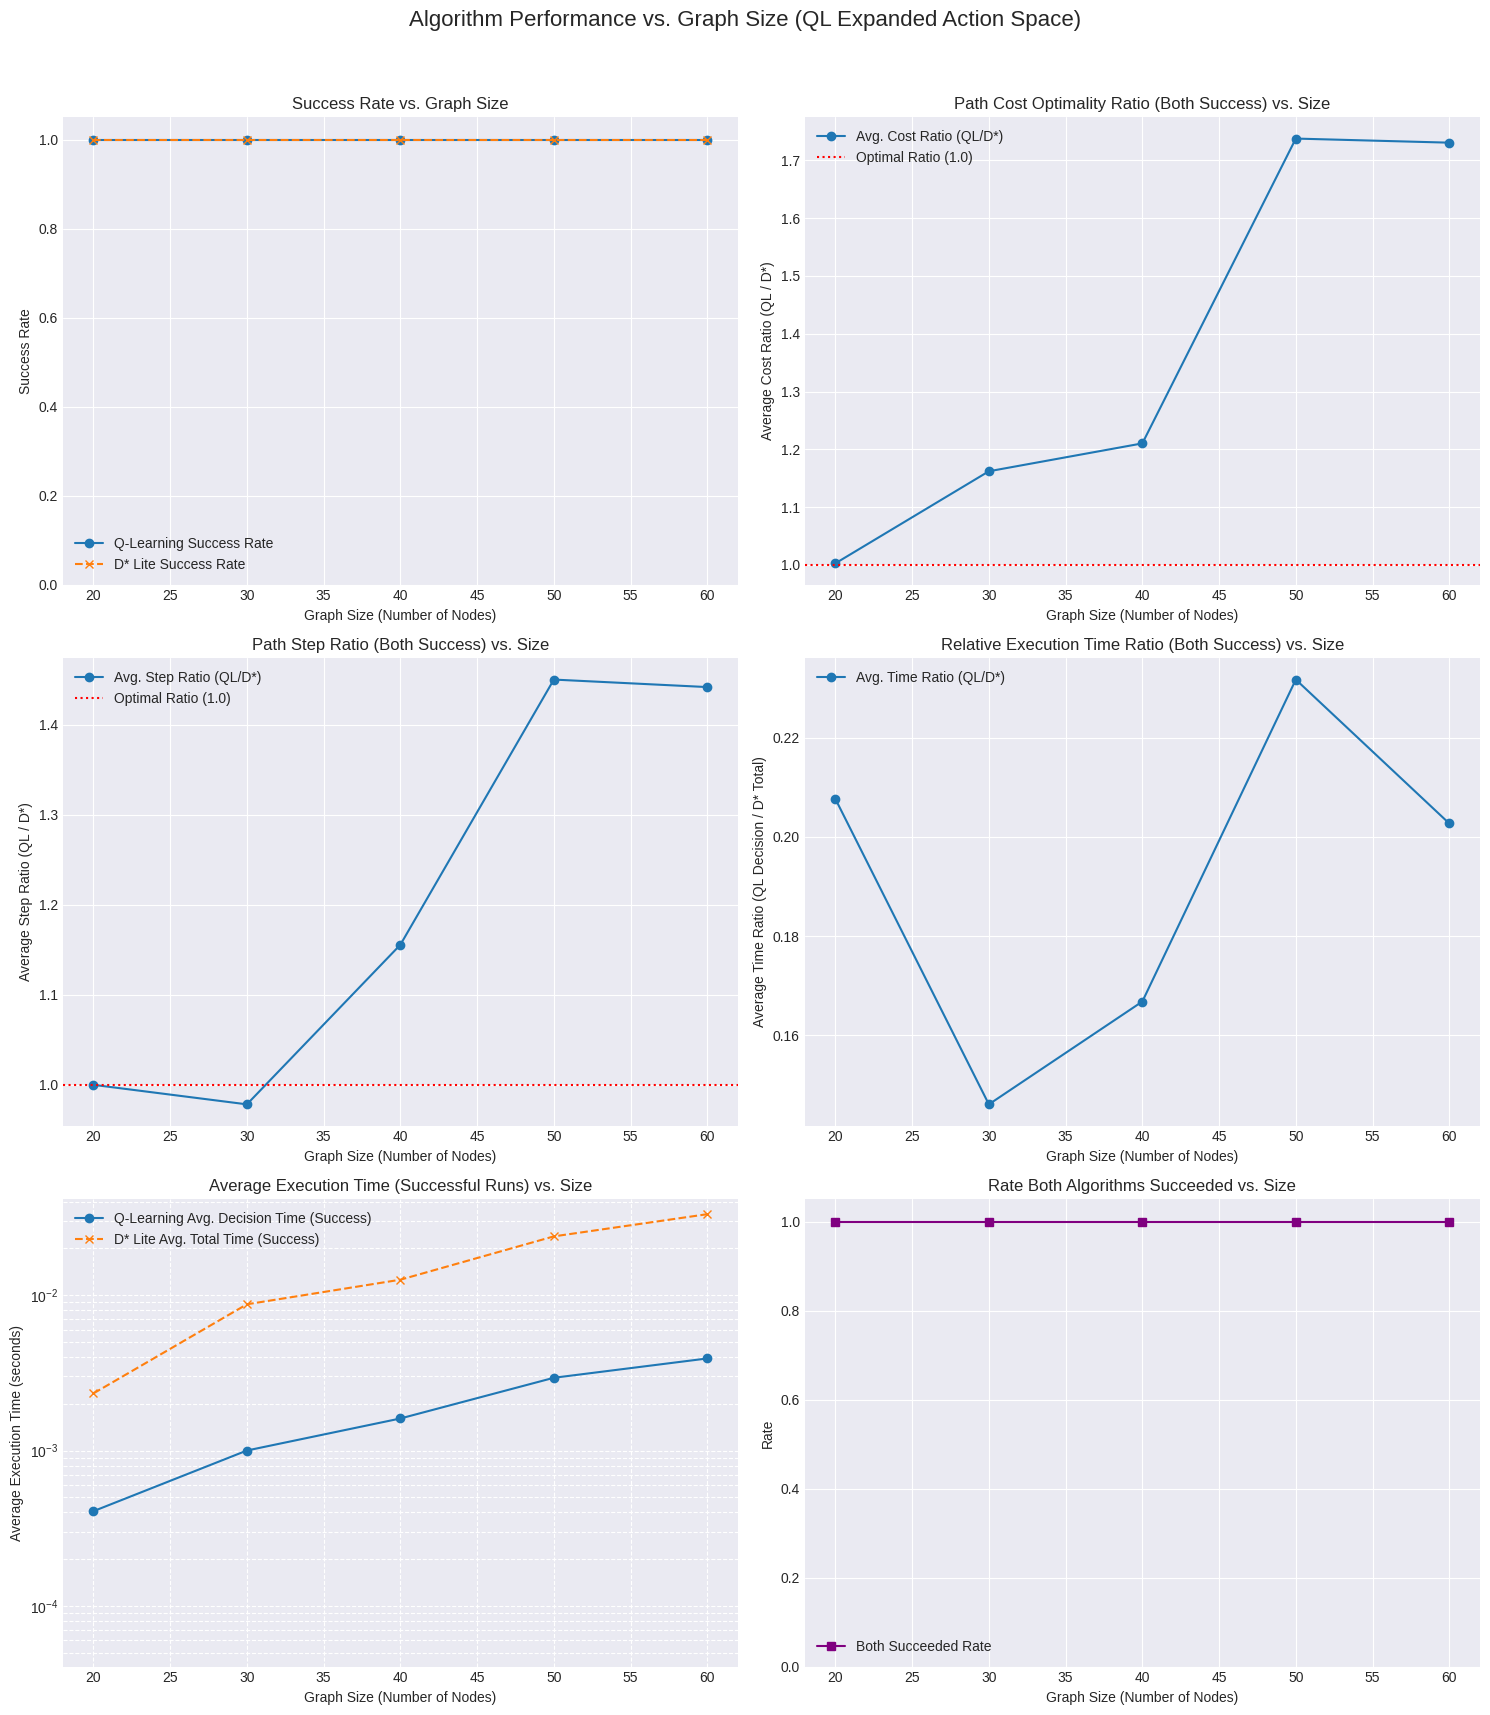


--- Experiment Finished ---


In [1]:
# -*- coding: utf-8 -*-
"""Q-Learning - Expanded Action Space

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1LRoRTVJay-IkQrEPrd8kF7TFugKBOJeo
"""

# --- Imports ---
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import time
import heapq
from collections import defaultdict, deque
import copy
import json # For potentially saving results

# --- Constants ---
# Define a penalty significantly worse than any possible negative edge weight reward
INVALID_MOVE_PENALTY = -200.0

# --- Modified Graph Creation with Scalable Index Pattern ---
# (Graph creation code remains IDENTICAL to your original version)
def create_dynamic_graph(num_nodes=20, seed=42, connectivity=0.3,
                         busy_node_pattern_interval=5):
    """
    Creates a deterministic random graph with time-varying edge weights,
    assigns node positions, and selects busy nodes based on a consistent
    index interval pattern to ensure scalable distribution.
    """
    if num_nodes <= 0:
        print("Warning: num_nodes must be positive. Returning empty graph.")
        return nx.Graph()

    # Set seeds for reproducibility FOR THIS SPECIFIC GRAPH SIZE
    random.seed(seed)
    np.random.seed(seed)

    # Create a random graph (undirected)
    G = nx.erdos_renyi_graph(n=num_nodes, p=connectivity, seed=seed)

    # --- Ensure Connectivity ---
    max_attempts = num_nodes * 2
    attempts = 0
    # Only try to connect if there's more than one node
    if G.number_of_nodes() > 1:
        while not nx.is_connected(G) and attempts < max_attempts :
            components = list(nx.connected_components(G))
            if len(components) > 1:
                # Connect a random node from a smaller component to the largest one
                largest_component = max(components, key=len)
                other_components = [c for c in components if c != largest_component]
                # Choose a random component that is not the largest
                if not other_components: # Should not happen if len(components)>1, but safety check
                    break
                comp_to_connect = random.choice(other_components)

                u = random.choice(list(largest_component))
                v = random.choice(list(comp_to_connect))
                G.add_edge(u, v)
            else: # Graph has edges but somehow len(components) <= 1 (should be connected)
                 break
            attempts += 1

        if attempts >= max_attempts and not nx.is_connected(G):
             print(f"Warning: Could not ensure graph connectivity for size {num_nodes} after {max_attempts} attempts.")

    # --- Define busy nodes using the scalable index pattern ---
    busy_nodes = []
    if num_nodes > 0 and busy_node_pattern_interval > 0:
        # Select nodes where index modulo interval is 0
        busy_nodes = [i for i in range(num_nodes) if i % busy_node_pattern_interval == 0]
    elif num_nodes > 0:
        print(f"Warning: Invalid busy_node_pattern_interval ({busy_node_pattern_interval}). No busy nodes selected.")

    # --- Assign initial edge weights and dynamic parameters ---
    for u, v in G.edges():
        is_busy_edge = (u in busy_nodes) or (v in busy_nodes)
        # Consistent weight distribution logic
        base_weight = random.uniform(7.0, 10.0) if is_busy_edge else random.uniform(1.0, 4.0)

        G[u][v]['weight'] = base_weight
        G[u][v]['base_weight'] = base_weight
        G[u][v]['variation'] = random.uniform(0.5, 2.5) # Consistent dynamic range
        G[u][v]['period'] = random.uniform(0.05, 0.3)   # Consistent dynamic speed

    # --- Assign node positions ---
    try:
        if G.number_of_nodes() > 50: # Use a potentially faster/better layout for large graphs
            G.pos = nx.kamada_kawai_layout(G)
        elif G.number_of_nodes() > 0:
            G.pos = nx.spring_layout(G, seed=seed) # Spring layout for smaller graphs
        else:
            G.pos = {} # Empty dict for empty graph
    except Exception as e: # Catch any layout error
         print(f"Warning: Layout algorithm failed for size {num_nodes} (seed={seed}, error={e}). Using random layout.")
         G.pos = nx.random_layout(G, seed=seed) if G.nodes else {}

    # Ensure pos attribute exists
    if not hasattr(G, 'pos'):
         G.pos = nx.random_layout(G, seed=seed) if G.nodes else {}

    # Ensure nodes are indexed 0 to N-1 for the expanded action space QL
    if set(G.nodes()) != set(range(G.number_of_nodes())):
        print(f"Warning: Graph nodes are not indexed 0 to N-1. Relabeling...")
        G = nx.convert_node_labels_to_integers(G, first_label=0)
        # Recompute positions if layout depended on original labels
        try:
             if G.number_of_nodes() > 50: G.pos = nx.kamada_kawai_layout(G)
             elif G.number_of_nodes() > 0: G.pos = nx.spring_layout(G, seed=seed)
             else: G.pos = {}
        except Exception as e:
             print(f"Warning: Re-layout failed after relabeling: {e}. Using random.")
             G.pos = nx.random_layout(G, seed=seed) if G.nodes else {}
        print("Relabeling complete.")

    return G

# --- Graph Utilities ---
# (Graph utilities update_edge_weights, reset_graph_weights remain IDENTICAL)
def update_edge_weights(G, time_step):
    """Updates edge weights based on time step."""
    if not G or not G.edges: return G
    for u, v in G.edges():
        base = G[u][v].get('base_weight', 5.0)
        variation = G[u][v].get('variation', 1.0)
        period = G[u][v].get('period', 0.2)
        try:
            factor = np.sin(time_step * period) * variation
            G[u][v]['weight'] = max(0.1, base + factor)
        except Exception: G[u][v]['weight'] = base
    return G

def reset_graph_weights(G):
    """Resets edge weights to base values."""
    if not G or not G.edges: return G
    for u, v in G.edges():
        G[u][v]['weight'] = G[u][v].get('base_weight', random.uniform(1, 10))
    return G


# --- D* Lite Implementation ---
# (DStarLite class and navigate_with_dstar function remain IDENTICAL)
class DStarLite:
    # --- D* Lite Code (Exactly as in the previous corrected version) ---
    def __init__(self, graph, start, goal):
        self.G = graph # Should be a NetworkX Graph (undirected assumed)
        self.start = start
        self.goal = goal
        self.current = start # Agent's current position

        self.U = [] # Priority queue (min-heap)
        self.g = defaultdict(lambda: float('inf'))
        self.rhs = defaultdict(lambda: float('inf'))
        self.km = 0 # Key modifier for heuristic updates

        self.rhs[goal] = 0
        try:
            initial_key = self.calculate_key(goal)
            if not isinstance(initial_key, tuple) or len(initial_key) != 2:
                raise TypeError(f"Initial key for goal {goal} is not a valid tuple: {initial_key}")
            heapq.heappush(self.U, (initial_key, goal))
        except TypeError as e:
             print(f"Error pushing initial goal node {goal} to heap: {e}")
             print(f"Goal key calculation resulted in: {self.calculate_key(goal)}")
             raise

    def calculate_key(self, node):
        """Calculate the key for a node in the priority queue"""
        g_val = self.g[node]
        rhs_val = self.rhs[node]
        min_g_rhs = min(g_val, rhs_val)

        h_cost = self.heuristic(self.start, node)
        if not isinstance(h_cost, (int, float)): h_cost = 0
        return (min_g_rhs + h_cost + self.km, min_g_rhs)

    def heuristic(self, a, b):
        """Heuristic function (Euclidean distance if positions exist)"""
        if a not in self.G or b not in self.G: return 0
        if not hasattr(self.G, 'pos') or not self.G.pos: return 0
        if a not in self.G.pos or b not in self.G.pos: return 0
        pos_a, pos_b = self.G.pos[a], self.G.pos[b]
        if (isinstance(pos_a, (list, tuple)) and len(pos_a) >= 2 and
            isinstance(pos_b, (list, tuple)) and len(pos_b) >= 2 and
            all(isinstance(coord, (int, float)) for coord in pos_a[:2] + pos_b[:2])):
             try: return math.sqrt((pos_a[0] - pos_b[0])**2 + (pos_a[1] - pos_b[1])**2)
             except (TypeError, ValueError): return 0
        return 0

    def update_vertex(self, u):
        """Update the RHS value and priority queue entry for a vertex"""
        if u != self.goal:
            min_rhs = float('inf')
            # Use G.neighbors safely
            if u in self.G:
                for v in self.G.neighbors(u):
                     cost = self.get_edge_cost(u, v)
                     if cost != float('inf') and self.g[v] != float('inf'):
                         min_rhs = min(min_rhs, cost + self.g[v])
            self.rhs[u] = min_rhs

        # Check if u is in the priority queue U before attempting removal/update
        u_in_queue = False
        temp_queue = []
        while self.U:
            key, node = heapq.heappop(self.U)
            if node == u:
                u_in_queue = True
                # Do not push back yet, let the logic below decide
            else:
                heapq.heappush(temp_queue, (key, node))
        self.U = temp_queue # Restore the queue without u

        if self.g[u] != self.rhs[u]:
            try:
                 key_u = self.calculate_key(u)
                 if not isinstance(key_u, tuple) or len(key_u) != 2: raise TypeError(f"Invalid key: {key_u}")
                 heapq.heappush(self.U, (key_u, u))
            except TypeError as e:
                 print(f"Error pushing node {u} during update: {e}, Key: {self.calculate_key(u)}")


    def get_edge_cost(self, u, v):
         """Safely get edge cost."""
         if self.G.has_edge(u, v):
             weight = self.G[u][v].get('weight', float('inf'))
             # Ensure weight is float/int before returning
             return float(weight) if isinstance(weight, (int, float)) else float('inf')
         return float('inf')

    def compute_shortest_path(self):
        """Compute shortest path values."""
        # Limit computation steps to prevent infinite loops in problematic cases
        max_compute_steps = self.G.number_of_nodes() * self.G.number_of_edges() * 2 + 1000 # Added buffer
        compute_steps = 0

        # Continue while the queue has elements AND
        # (top key is less than start's key OR start is inconsistent)
        while self.U and (not self.U or self.U[0][0] < self.calculate_key(self.start) or self.rhs[self.start] != self.g[self.start]):
            compute_steps += 1
            if compute_steps > max_compute_steps:
                 print(f"Warning: Exceeded D* compute step limit ({max_compute_steps}). Start G={self.g[self.start]}, RHS={self.rhs[self.start]}")
                 # Optional: Print queue state for debugging
                 # print("Queue top:", self.U[0] if self.U else "Empty")
                 # print("Start key:", self.calculate_key(self.start))
                 break

            try:
                k_old, u = heapq.heappop(self.U)
            except IndexError:
                # print("D* Compute: Heap empty.")
                break # Queue is empty

            k_new = self.calculate_key(u)

            if k_old < k_new:
                # Key increased, needs re-insertion with new key
                try:
                    heapq.heappush(self.U, (k_new, u))
                except TypeError as e:
                    print(f"Error pushing {u} (key increased): {e}, Key: {k_new}")
            elif self.g[u] > self.rhs[u]:
                # Node is locally under-consistent, update g value
                self.g[u] = self.rhs[u]
                # Propagate changes to predecessors (neighbors)
                if u in self.G: # Check if node exists before getting neighbors
                    for s in self.G.neighbors(u):
                        self.update_vertex(s)
            else:
                # Node is locally over-consistent (g <= rhs)
                # Set g to infinity and update self and predecessors
                g_old = self.g[u]
                self.g[u] = float('inf')
                affected_nodes = []
                if u in self.G:
                    affected_nodes = list(self.G.neighbors(u))
                affected_nodes.append(u) # Include the node itself

                for s in affected_nodes:
                    self.update_vertex(s)

            # Safety check for excessive queue growth (might indicate issues)
            if len(self.U) > self.G.number_of_nodes() * 5:
                print(f"Warning: D* queue size potentially excessive ({len(self.U)}).")
                # Consider adding logic to prune or investigate if this happens often

    def get_next_node(self):
        """Get the best next node based on minimizing cost + g_value."""
        if self.current == self.goal:
            return None # Already at the goal

        min_cost_plus_g = float('inf')
        next_node = None

        if self.current not in self.G:
            print(f"Warning: Current node {self.current} not in graph G during get_next_node.")
            return None # Cannot find neighbors

        neighbors = list(self.G.neighbors(self.current))
        if not neighbors:
             print(f"Warning: Current node {self.current} has no neighbors.")
             return None # No possible moves


        for neighbor in neighbors:
            cost = self.get_edge_cost(self.current, neighbor)
            g_neighbor = self.g[neighbor]

            # Ensure costs are valid numbers before calculation
            if cost == float('inf') or g_neighbor == float('inf'):
                continue # Skip neighbors with infinite path cost or edge cost

            current_cost_plus_g = cost + g_neighbor

            if current_cost_plus_g < min_cost_plus_g:
                min_cost_plus_g = current_cost_plus_g
                next_node = neighbor
            # Tie-breaking: Prefer lower heuristic, then lower node index
            elif current_cost_plus_g == min_cost_plus_g and next_node is not None:
                 h_neighbor = self.heuristic(neighbor, self.goal)
                 h_next_node = self.heuristic(next_node, self.goal)
                 if h_neighbor < h_next_node:
                     next_node = neighbor
                 elif h_neighbor == h_next_node and neighbor < next_node: # Lexicographical tie-break
                     next_node = neighbor


        # if next_node is None and self.current != self.goal:
        #     print(f"Warning: D* could not find a valid next node from {self.current} towards {self.goal}.")
        #     print(f"  Neighbors: {list(self.G.neighbors(self.current))}")
        #     print(f"  Costs+g: {[(n, self.get_edge_cost(self.current, n) + self.g[n]) for n in self.G.neighbors(self.current)]}")
        #     print(f"  g-values: {[(n, self.g[n]) for n in self.G.neighbors(self.current)]}")
        #     print(f"  rhs-values: {[(n, self.rhs[n]) for n in self.G.neighbors(self.current)]}")
        #     print(f"  g[start={self.start}]: {self.g[self.start]}, rhs[start]: {self.rhs[self.start]}")


        return next_node


    def move_to(self, node):
        """Update agent's current position and potentially the km value."""
        if node is not None and node != self.current:
            # --- Standard D* Lite includes km update based on heuristic change ---
            # new_km = self.km + self.heuristic(self.current, node) # Simplified example
            # if new_km != self.km:
            #    self.km = new_km
            #    # Needs logic to update keys in the priority queue U if km changes
            #    # This adds complexity, often omitted in basic examples unless necessary
            #    # For this problem, since heuristic is static Euclidean, km won't change much
            #    # relative to the start position if start position changes? Let's keep km=0 for simplicity.
            #    pass
            # --- Update position ---
            self.current = node
            # D* Lite plans from goal to start, so we update 'start' as the agent moves
            self.start = node


    def notify_edge_changes(self, changed_edges):
        """Notify D* about edge cost changes and trigger replanning."""
        # --- D* Lite approach: Update affected vertices directly ---
        nodes_to_update = set()
        for u, v in changed_edges:
            # We need to update vertices whose RHS value might change.
            # This happens if the cost(u, v) changed, affecting rhs[u] and rhs[v].
            # Also, if g[u] or g[v] changes, it affects neighbors' rhs.
            # A simpler, slightly less efficient approach is to update both endpoints.
            if u in self.G: nodes_to_update.add(u)
            if v in self.G: nodes_to_update.add(v)
            # More correctly, we should update u if cost(u,v)+g(v) affects rhs(u)
            # and v if cost(v,u)+g(u) affects rhs(v).

        if not nodes_to_update:
             return # No relevant nodes to update

        # Update the vertices - this handles RHS recalculation and queue management
        for node in nodes_to_update:
            self.update_vertex(node)

        # After updating vertices potentially affected by edge changes,
        # recompute shortest path values.
        self.compute_shortest_path()


def navigate_with_dstar(graph_instance, start_node, goal_node, max_steps=None):
    """Navigate using D* Lite, handling dynamic weights during navigation."""
    print(f"\n--- D* Lite Navigation: {start_node} -> {goal_node} (Size: {graph_instance.number_of_nodes()}) ---")
    G_nav = graph_instance
    if start_node not in G_nav or goal_node not in G_nav:
        print(f"Error: Start ({start_node}) / Goal ({goal_node}) node not in graph.")
        return [], float('inf'), 0, 0.0

    # Ensure graph weights are reset at the beginning of navigation
    reset_graph_weights(G_nav)

    try:
        planner = DStarLite(G_nav, start_node, goal_node)
    except Exception as e:
        print(f"Error initializing D*: {e}")
        import traceback
        traceback.print_exc()
        return [], float('inf'), 0, 0.0

    current_node = start_node
    current_time = 0 # Represents simulation time steps
    total_cost = 0.0
    path = [current_node]

    if max_steps is None:
        max_steps = G_nav.number_of_nodes() * 2 # Heuristic limit

    start_time_exec = time.perf_counter()

    # Initial plan computation
    try:
        planner.compute_shortest_path()
    except Exception as e:
        print(f"Error during initial D* compute: {e}")
        end_time_exec = time.perf_counter()
        return [], float('inf'), 0, end_time_exec - start_time_exec

    # Check if a path is possible initially
    if planner.g[start_node] == float('inf'):
         print(f"D* Lite: Initial path calculation failed (g[{start_node}]=inf). Goal might be unreachable.")
         end_time_exec = time.perf_counter()
         return [], float('inf'), 0, end_time_exec - start_time_exec

    # Navigation loop
    while current_node != goal_node and current_time < max_steps:
        # 1. Update environment (edge weights) based on current time
        #    Store old weights to find changed edges (more efficient than passing all)
        old_weights = {(u, v): G_nav[u][v]['weight'] for u, v in G_nav.edges()}
        update_edge_weights(G_nav, current_time)
        changed_edges = []
        for u, v in G_nav.edges():
             if G_nav[u][v]['weight'] != old_weights.get((u,v)):
                  changed_edges.append((u,v))
             # Handle potential tuple order difference if graph is undirected internally
             elif (v,u) in old_weights and G_nav[u][v]['weight'] != old_weights.get((v,u)):
                  changed_edges.append((u,v))


        # 2. Notify D* of changes and replan if necessary
        if changed_edges:
            try:
                planner.notify_edge_changes(changed_edges)
            except Exception as e:
                print(f"Error during D* notify/recompute at t={current_time}: {e}")
                total_cost=float('inf')
                break # Critical error during replanning

        # 3. Determine the next move based on the current plan
        next_node = planner.get_next_node()

        # 4. Check if a move is possible
        if next_node is None:
            if current_node == goal_node:
                break # Successfully reached goal in the previous step
            else:
                print(f"D* Lite: No path found from {current_node} towards {goal_node} at t={current_time}.")
                # Check if goal became unreachable
                # print(f"  Current g[start={planner.start}]: {planner.g[planner.start]}, rhs[start]: {planner.rhs[planner.start]}")
                total_cost = float('inf')
                break # Agent is stuck

        # 5. Calculate cost of the chosen move *at this time step*
        edge_cost = planner.get_edge_cost(current_node, next_node)
        if edge_cost == float('inf'):
             # This shouldn't happen if get_next_node worked correctly unless weights changed between get_next_node and get_edge_cost
             print(f"D* Error: Planned edge ({current_node},{next_node}) has infinite cost at t={current_time}! Graph state potentially inconsistent.")
             total_cost = float('inf')
             break

        total_cost += edge_cost

        # 6. Move the agent
        planner.move_to(next_node)
        current_node = next_node # Update loop variable
        path.append(current_node)
        current_time += 1

        # Optional: Add a small delay for visualization or debugging
        # time.sleep(0.1)

    end_time_exec = time.perf_counter()
    elapsed_time = end_time_exec - start_time_exec
    success = (current_node == goal_node and total_cost != float('inf'))

    status = 'Reached goal' if success else ('Max steps reached' if current_time >= max_steps else 'Failed (stuck or error)')
    print(f"D* Lite: {status}.")
    if success:
        print(f"  Path: {path}")
        print(f"  Cost: {total_cost:.2f}, Steps: {current_time}, Time: {elapsed_time:.4f}s")
    elif path: # Print partial path if failed but moved somewhat
        print(f"  Partial Path: {path}")
        print(f"  Final Cost (if failed): {'Infinite' if total_cost == float('inf') else f'{total_cost:.2f}'}, Steps: {current_time}, Time: {elapsed_time:.4f}s")


    # Return path only if successful
    return path if success else [], total_cost if success else float('inf'), current_time, elapsed_time


# --- Q-Learning Implementation (Expanded Action Space Version) ---
class QLearningPathFinder:
    def __init__(self, graph, learning_rate=0.1, discount_factor=0.9, exploration_rate=1.0, exploration_decay=0.999, min_exploration_rate=0.05):
        self.G_template = graph # Store the template graph structure/params
        self.nodes = list(graph.nodes()) if graph else []
        # *** Ensure nodes are 0 to N-1 for expanded action space ***
        if graph and set(self.nodes) != set(range(graph.number_of_nodes())):
             raise ValueError("Graph nodes must be integers from 0 to N-1 for expanded action space QL.")
        self.num_nodes = len(self.nodes)
        self.alpha = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_rate
        self.epsilon_decay = exploration_decay
        self.min_epsilon = min_exploration_rate
        # Q-table: state -> action -> value
        # State = (current_node, goal_node)
        # Action = target_node (integer from 0 to num_nodes-1)
        self.q_table = defaultdict(lambda: defaultdict(float))
        self.experience = deque(maxlen=20000) # Increased experience buffer size potentially needed
        self.positions = getattr(self.G_template, 'pos', None) # For potential heuristic use (not used here)

    def get_state(self, current_node, goal_node):
        """Returns the state representation."""
        return (current_node, goal_node)

    def choose_action(self, state, is_training=True):
        """
        Chooses an action based on epsilon-greedy strategy.
        Action space is ALL nodes (0 to num_nodes-1).
        """
        if self.num_nodes == 0: return None

        possible_actions = list(range(self.num_nodes)) # Consider ALL nodes as potential actions

        # Exploration
        if is_training and random.random() < self.epsilon:
            return random.choice(possible_actions)

        # Exploitation
        q_values = self.q_table[state]
        best_q_value = -float('inf')
        best_actions = []

        # Evaluate Q-value for *every* possible node action
        for action_node in possible_actions:
            q_val = q_values[action_node] # Defaults to 0.0 if not seen
            if q_val > best_q_value:
                best_q_value = q_val
                best_actions = [action_node]
            elif q_val == best_q_value:
                best_actions.append(action_node)

        # Choose among the best actions (randomly breaks ties)
        if best_actions:
            return random.choice(best_actions)
        else:
            # If all Q-values are -inf or no actions somehow (shouldn't happen here)
            # Fallback to random action
            return random.choice(possible_actions)

    def calculate_reward(self, G_instance, current_node, next_node, goal_node):
        """
        Calculates reward ONLY for VALID moves (checked outside this function).
        Assumes G_instance.has_edge(current_node, next_node) is TRUE.
        """
        # This function now assumes the move is valid, penalty handled externally
        edge_weight = G_instance[current_node][next_node].get('weight', 100.0) # Default high cost if missing
        if not isinstance(edge_weight, (int, float)) or edge_weight < 0:
            edge_weight = 100.0 # Fallback for invalid weights

        reward = -edge_weight # Negative cost

        # Bonus for reaching the goal
        if next_node == goal_node:
            reward += 100.0 # Goal bonus

        return reward

    def update_q_value(self, state, action, reward, next_state, next_available_actions):
        """
        Updates the Q-value for a given state-action pair.
        Uses the standard Q-learning update rule.
        `next_available_actions` should be the *valid* neighbors of the resulting state.
        """
        # Find the maximum Q-value for the *next* state over *valid* future actions
        max_next_q = -float('inf') # Initialize lower than potential penalties
        if next_available_actions: # Only consider if there are valid moves from next state
            next_q_values = self.q_table[next_state]
            # *** IMPORTANT: Consider Q-values only for valid actions from the next state ***
            # Although the action space is expanded, the max_q for the *update*
            # usually considers the best outcome achievable from the next state,
            # which involves taking a valid next step.
            # Alternatively, one could consider max_q over *all* nodes again, but
            # this might lead to slower learning if invalid move penalties dominate.
            # Let's stick to max over valid neighbors for the TD target.
            current_max = -float('inf')
            for next_act in next_available_actions:
                 current_max = max(current_max, next_q_values[next_act]) # Defaults to 0.0
            max_next_q = current_max if current_max > -float('inf') else 0.0 # Ensure it's at least 0 if no positive Q found

        else: # Terminal state (goal reached or stuck with no neighbors)
            max_next_q = 0.0

        # Q-learning update rule
        current_q = self.q_table[state][action]
        new_q = current_q + self.alpha * (reward + self.gamma * max_next_q - current_q)
        self.q_table[state][action] = new_q

    def experience_replay(self, batch_size=32):
        """Learns from a random batch of past experiences."""
        if len(self.experience) < batch_size:
            return # Not enough experience yet

        # Sample a mini-batch randomly from the experience buffer
        mini_batch = random.sample(self.experience, batch_size)

        # Update Q-values for each transition in the mini-batch
        for state, action, reward, next_state, next_available_actions in mini_batch:
            self.update_q_value(state, action, reward, next_state, next_available_actions)

    def train(self, num_episodes=5000, max_steps_per_episode=100, experience_replay_batch_size=64):
        """Trains the Q-learning agent."""
        print(f"\n--- Starting QL Training (Expanded Action Space, Size: {self.num_nodes}, Episodes: {num_episodes}) ---")
        stats = {'episode_rewards': [], 'episode_steps': []}
        if self.num_nodes < 2:
            print("Warning: Too few nodes for meaningful training. Skipping.")
            return stats

        # Use a copy of the graph for training simulations
        G_train = self.G_template.copy()
        if hasattr(self.G_template, 'pos'): G_train.pos = self.G_template.pos

        start_train_time = time.perf_counter()
        nodes = list(self.nodes) # Should be 0 to N-1

        for ep in range(num_episodes):
            # Randomly select start and goal nodes for the episode
            start_node, goal_node = random.sample(nodes, 2)
            current_node = start_node
            total_episode_reward = 0.0
            time_step = 0 # Simulation time within the episode

            # Reset graph weights for the start of the episode
            reset_graph_weights(G_train)

            for step in range(max_steps_per_episode):
                # Update dynamic edge weights based on simulation time
                update_edge_weights(G_train, time_step)

                # Get the current state
                state = self.get_state(current_node, goal_node)

                # Agent chooses an action from ALL possible nodes
                chosen_action_node = self.choose_action(state, is_training=True)

                # --- Environment Interaction: Determine outcome of the chosen action ---
                is_valid_move = G_train.has_edge(current_node, chosen_action_node)
                reward = 0.0
                actual_next_node = -1 # Placeholder

                if is_valid_move:
                    # Calculate reward based on edge weight
                    reward = self.calculate_reward(G_train, current_node, chosen_action_node, goal_node)
                    actual_next_node = chosen_action_node
                else:
                    # Apply penalty for invalid move
                    reward = INVALID_MOVE_PENALTY
                    actual_next_node = current_node # Agent stays in the same place

                total_episode_reward += reward

                # --- Prepare for Q-update ---
                next_state = self.get_state(actual_next_node, goal_node)

                # Get VALID actions available from the *actual* next state for the max_q calculation
                if actual_next_node == goal_node:
                    next_available_actions = []
                elif actual_next_node in G_train:
                    next_available_actions = list(G_train.neighbors(actual_next_node))
                else: # Should not happen if graph nodes are 0..N-1
                     print(f"Error: actual_next_node {actual_next_node} not in G_train during training.")
                     next_available_actions = []


                # Store the experience (using the CHOSEN action, not the actual outcome)
                self.experience.append((state, chosen_action_node, reward, next_state, next_available_actions))

                # Perform experience replay
                if len(self.experience) > experience_replay_batch_size:
                    self.experience_replay(experience_replay_batch_size)
                # Optional: Direct Q-update (can be done alongside replay)
                # self.update_q_value(state, chosen_action_node, reward, next_state, next_available_actions)

                # Move to the actual next node
                current_node = actual_next_node
                time_step += 1

                # Check if goal is reached
                if current_node == goal_node:
                    break # End episode

            # --- End of Episode ---
            stats['episode_rewards'].append(total_episode_reward)
            stats['episode_steps'].append(step + 1)

            # Decay exploration rate
            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

            # Print progress periodically
            if (ep + 1) % (num_episodes // 10 or 500) == 0:
                 if len(stats['episode_rewards']) >= 100:
                    avg_r = np.mean(stats['episode_rewards'][-100:])
                    avg_s = np.mean(stats['episode_steps'][-100:])
                    print(f"  Ep {ep+1}/{num_episodes} | Avg R(100): {avg_r:.2f} | Avg S(100): {avg_s:.1f} | Eps: {self.epsilon:.3f}")
                 else:
                    print(f"  Ep {ep+1}/{num_episodes} | Eps: {self.epsilon:.3f}")

        print(f"--- QL Training Finished in {time.perf_counter() - start_train_time:.2f}s ---")
        return stats


# --- Q-Learning Path Execution (Inference Only - Expanded Action Space Version) ---
def execute_ql_policy(ql_agent, graph_instance, start_node, goal_node, max_steps=None):
    """Finds a path using the learned Q-policy (inference). Action space is expanded."""
    print(f"\n--- QL Policy Execution (Expanded Action Space): {start_node} -> {goal_node} (Size: {graph_instance.number_of_nodes()}) ---")
    G_exec = graph_instance
    if start_node not in G_exec or goal_node not in G_exec:
         print(f"Error: Start/Goal node not in graph."); return [], float('inf'), 0, 0.0

    # Reset graph weights for the execution run
    reset_graph_weights(G_exec)

    current_node = start_node
    time_step = 0
    total_cost = 0.0
    path = [current_node]

    if max_steps is None:
        max_steps = ql_agent.num_nodes * 3 # Increased max steps slightly

    start_time = time.perf_counter()
    while current_node != goal_node and time_step < max_steps:
        # Update dynamic edge weights
        update_edge_weights(G_exec, time_step)

        # Get current state
        state = ql_agent.get_state(current_node, goal_node)

        # Agent chooses action from ALL nodes (exploitation only)
        chosen_action_node = ql_agent.choose_action(state, is_training=False)
        if chosen_action_node is None:
             print(f"QL: Cannot choose action from {current_node} (t={time_step}). Q-table missing?"); path=[]; total_cost=float('inf'); break

        # --- Environment Interaction: Check validity and calculate cost/next state ---
        is_valid_move = G_exec.has_edge(current_node, chosen_action_node)
        actual_next_node = -1

        if is_valid_move:
            # Get the cost of the valid edge at the current time
            edge_cost = G_exec[current_node][chosen_action_node].get('weight', float('inf'))
            if edge_cost == float('inf') or not isinstance(edge_cost, (int, float)):
                 print(f"QL Error: Valid edge ({current_node},{chosen_action_node}) has invalid cost: {edge_cost}."); path=[]; total_cost=float('inf'); break
            total_cost += edge_cost
            actual_next_node = chosen_action_node
        else:
            # Policy chose an invalid move during execution! This means learning might be incomplete or flawed.
            # We could stop, or penalize and stay put. Let's stop and report failure.
             print(f"QL Policy Error: Chose invalid move from {current_node} to {chosen_action_node} at t={time_step}.")
             # print(f"  Q-value for chosen: {ql_agent.q_table[state][chosen_action_node]}")
             # neighbors = list(G_exec.neighbors(current_node))
             # print(f"  Valid neighbors: {neighbors}")
             # print(f"  Q-values for neighbors: { {n: ql_agent.q_table[state][n] for n in neighbors} }")
             path = []
             total_cost = float('inf')
             break # Critical failure if policy selects invalid move

        # Move agent
        current_node = actual_next_node
        path.append(current_node)
        time_step += 1

    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    success = (current_node == goal_node and total_cost != float('inf'))

    status = 'Reached goal' if success else ('Max steps reached' if time_step >= max_steps else 'Failed (Policy Error or Stuck)')
    print(f"QL Policy: {status}.")
    if success:
        print(f"  Path: {path}")
        print(f"  Cost: {total_cost:.2f}, Steps: {time_step}, Time: {elapsed_time:.4f}s")
    elif path: # Print partial path if failed
        print(f"  Partial Path: {path}")
        print(f"  Final Cost: {'Infinite' if total_cost == float('inf') else f'{total_cost:.2f}'}, Steps: {time_step}, Time: {elapsed_time:.4f}s")


    return path if success else [], total_cost if success else float('inf'), time_step, elapsed_time


# --- Benchmarking Framework ---
# (benchmark_algorithms function remains IDENTICAL - it just calls the new execute_ql_policy)
def benchmark_algorithms(graph_template, ql_agent, num_test_pairs=10, max_steps_per_run=None):
    """Compares D* Lite and trained Q-Learning on multiple pathfinding tasks."""
    n_nodes = graph_template.number_of_nodes()
    print(f"\n--- Running Benchmark (Size: {n_nodes}, Pairs: {num_test_pairs}) ---")
    nodes_list = list(graph_template.nodes())
    if n_nodes < 2: print("Need >= 2 nodes."); return None
    if max_steps_per_run is None: max_steps_per_run = n_nodes * 3 # Adjusted default

    # Generate unique test pairs
    test_pairs = set()
    attempts = 0; max_attempts = num_test_pairs * 5
    while len(test_pairs) < num_test_pairs and attempts < max_attempts:
        # Ensure source and dest are different
        pair = tuple(random.sample(nodes_list, 2))
        test_pairs.add(pair)
        attempts += 1

    test_pairs = list(test_pairs)
    if len(test_pairs) < num_test_pairs: print(f"Warning: Generated {len(test_pairs)} unique pairs (requested {num_test_pairs}).")
    if not test_pairs: print("No test pairs generated."); return {'detailed_results': [], 'summary': {}}


    results = []
    all_ql_times, all_dstar_times = [], []
    all_ql_costs, all_dstar_costs = [], []
    all_ql_steps, all_dstar_steps = [], []
    successful_ql, successful_dstar, both_successful = 0, 0, 0

    for i, (source, dest) in enumerate(test_pairs):
        print(f"\n===== Test Pair {i+1}/{len(test_pairs)}: {source} -> {dest} (Size: {n_nodes}) =====")
        # Ensure fresh graph copies for each run
        try:
             # Critical: Deep copy ensures weights and dynamic state are independent
             G_dstar = copy.deepcopy(graph_template)
             G_ql = copy.deepcopy(graph_template)
             if not hasattr(G_dstar, 'pos'): G_dstar.pos = graph_template.pos # Ensure pos is copied if exists
             if not hasattr(G_ql, 'pos'): G_ql.pos = graph_template.pos
        except Exception as e:
             print(f"Error deepcopying graph for pair {source}->{dest}: {e}")
             continue # Skip this pair

        # --- D* Lite Run ---
        # Reset weights specifically for this run (redundant if deepcopy worked perfectly, but safe)
        reset_graph_weights(G_dstar)
        dstar_path, dstar_cost, dstar_steps, dstar_time = navigate_with_dstar(
            G_dstar, source, dest, max_steps=max_steps_per_run)
        dstar_success = bool(dstar_path and dstar_path[-1] == dest and dstar_cost != float('inf'))

        # --- Q-Learning Run ---
        # Reset weights specifically for this run
        reset_graph_weights(G_ql)
        ql_path, ql_cost, ql_steps, ql_time = execute_ql_policy(
            ql_agent, G_ql, source, dest, max_steps=max_steps_per_run)
        ql_success = bool(ql_path and ql_path[-1] == dest and ql_cost != float('inf'))

        # Store results
        result_pair = {
            'source': source, 'destination': dest, 'size': n_nodes,
            'dstar_path': dstar_path, 'dstar_cost': dstar_cost, 'dstar_steps': dstar_steps,
            'dstar_time': dstar_time, 'dstar_success': dstar_success,
            'ql_path': ql_path, 'ql_cost': ql_cost, 'ql_steps': ql_steps,
            'ql_decision_time': ql_time, 'ql_success': ql_success,
            'cost_ratio': float('nan'), 'time_ratio': float('nan'), 'step_ratio': float('nan')
        }

        # Update aggregate stats and calculate ratios only if both succeeded
        valid_comparison = False
        if dstar_success:
            successful_dstar += 1
            all_dstar_costs.append(dstar_cost)
            all_dstar_steps.append(dstar_steps)
            all_dstar_times.append(dstar_time)
        if ql_success:
            successful_ql += 1
            all_ql_costs.append(ql_cost)
            all_ql_steps.append(ql_steps)
            all_ql_times.append(ql_time)

        if ql_success and dstar_success:
            both_successful += 1
            valid_comparison = True
            # Calculate ratios safely avoiding division by zero
            if dstar_cost > 1e-9: result_pair['cost_ratio'] = ql_cost / dstar_cost
            elif ql_cost < 1e-9: result_pair['cost_ratio'] = 1.0 # Both near zero cost
            else: result_pair['cost_ratio'] = float('inf') # QL has cost, D* has zero

            if dstar_time > 1e-9: result_pair['time_ratio'] = ql_time / dstar_time
            elif ql_time < 1e-9: result_pair['time_ratio'] = 1.0 # Both near zero time
            else: result_pair['time_ratio'] = float('inf')

            if dstar_steps > 0: result_pair['step_ratio'] = float(ql_steps) / dstar_steps
            elif ql_steps == 0: result_pair['step_ratio'] = 1.0 # Both zero steps
            else: result_pair['step_ratio'] = float('inf')


        results.append(result_pair)
        print("-" * 20) # Separator for readability
        print(f"D* Success: {dstar_success}, Cost: {'INF' if dstar_cost==float('inf') else f'{dstar_cost:.2f}'}, Steps: {dstar_steps}, Time: {dstar_time:.4f}s")
        print(f"QL Success: {ql_success}, Cost: {'INF' if ql_cost==float('inf') else f'{ql_cost:.2f}'}, Steps: {ql_steps}, Time: {ql_time:.4f}s")
        if valid_comparison:
            print(f"  Cost Ratio (QL/D*): {result_pair['cost_ratio']:.3f}")
            print(f"  Step Ratio (QL/D*): {result_pair['step_ratio']:.3f}")
            print(f"  Time Ratio (QL Decision / D* Total): {result_pair['time_ratio']:.3f}")

    # --- Calculate Summary Statistics ---
    summary = {}
    num_run = len(test_pairs)
    if num_run > 0:
         summary['num_test_pairs'] = num_run
         summary['node_size'] = n_nodes
         summary['ql_success_rate'] = successful_ql / num_run if num_run > 0 else 0.0
         summary['dstar_success_rate'] = successful_dstar / num_run if num_run > 0 else 0.0
         summary['both_success_rate'] = both_successful / num_run if num_run > 0 else 0.0
         summary['avg_ql_cost_success'] = np.mean(all_ql_costs) if all_ql_costs else float('nan') # Avg cost over successful QL runs
         summary['avg_dstar_cost_success'] = np.mean(all_dstar_costs) if all_dstar_costs else float('nan') # Avg cost over successful D* runs
         summary['avg_ql_steps_success'] = np.mean(all_ql_steps) if all_ql_steps else float('nan')
         summary['avg_dstar_steps_success'] = np.mean(all_dstar_steps) if all_dstar_steps else float('nan')
         summary['avg_ql_decision_time_success'] = np.mean(all_ql_times) if all_ql_times else float('nan')
         summary['avg_dstar_total_time_success'] = np.mean(all_dstar_times) if all_dstar_times else float('nan')

         # Calculate average ratios ONLY over pairs where BOTH algorithms succeeded
         valid_cost_ratios = [r['cost_ratio'] for r in results if r['ql_success'] and r['dstar_success'] and not np.isnan(r['cost_ratio'])]
         valid_time_ratios = [r['time_ratio'] for r in results if r['ql_success'] and r['dstar_success'] and not np.isnan(r['time_ratio'])]
         valid_step_ratios = [r['step_ratio'] for r in results if r['ql_success'] and r['dstar_success'] and not np.isnan(r['step_ratio'])]

         summary['avg_cost_ratio_both_success'] = np.mean(valid_cost_ratios) if valid_cost_ratios else float('nan')
         summary['median_cost_ratio_both_success'] = np.median(valid_cost_ratios) if valid_cost_ratios else float('nan')
         summary['avg_time_ratio_both_success'] = np.mean(valid_time_ratios) if valid_time_ratios else float('nan')
         summary['median_time_ratio_both_success'] = np.median(valid_time_ratios) if valid_time_ratios else float('nan')
         summary['avg_step_ratio_both_success'] = np.mean(valid_step_ratios) if valid_step_ratios else float('nan')
         summary['median_step_ratio_both_success'] = np.median(valid_step_ratios) if valid_step_ratios else float('nan')
         summary['num_both_successful'] = both_successful

    # --- Print Summary ---
    print("\n===== Benchmark Summary =====")
    if summary:
        print(f"Graph Size: {summary['node_size']}, Tested Pairs: {summary['num_test_pairs']}")
        print(f"Success Rate - QL: {summary['ql_success_rate']:.2%} | D*: {summary['dstar_success_rate']:.2%}")
        print(f"Both Succeeded Rate: {summary['both_success_rate']:.2%} ({summary.get('num_both_successful', 0)} pairs)")
        print("-" * 20 + f"\nAverages (on Successful Runs):")
        print(f"  Cost     - QL: {summary.get('avg_ql_cost_success', 'N/A'):.2f} (n={successful_ql}) | D*: {summary.get('avg_dstar_cost_success', 'N/A'):.2f} (n={successful_dstar})")
        print(f"  Steps    - QL: {summary.get('avg_ql_steps_success', 'N/A'):.1f} (n={successful_ql}) | D*: {summary.get('avg_dstar_steps_success', 'N/A'):.1f} (n={successful_dstar})")
        print(f"  Time     - QL Decision: {summary.get('avg_ql_decision_time_success', 'N/A'):.4f}s | D* Total: {summary.get('avg_dstar_total_time_success', 'N/A'):.4f}s")
        print("-" * 20 + f"\nRatios (on {summary.get('num_both_successful', 0)} pairs where Both Succeeded):")
        print(f"  Avg Cost Ratio (QL/D*): {summary.get('avg_cost_ratio_both_success', 'N/A'):.3f}")
        print(f"  Avg Step Ratio (QL/D*): {summary.get('avg_step_ratio_both_success', 'N/A'):.3f}")
        print(f"  Avg Time Ratio (QL / D*): {summary.get('avg_time_ratio_both_success', 'N/A'):.3f}")
    else:
        print("No valid results generated for summary.")

    return {'detailed_results': results, 'summary': summary}


# --- Plotting Function ---
# (Plotting function remains IDENTICAL - it uses the keys from the summary dict)
def plot_benchmark_results(all_benchmark_summaries):
    """Generates plots comparing performance metrics across graph sizes."""
    if not all_benchmark_summaries:
        print("No benchmark summaries available to plot.")
        return

    # Filter summaries that are not None and have the 'summary' key
    valid_summaries = [s for s in all_benchmark_summaries if s and 'summary' in s and s['summary']]

    if not valid_summaries:
        print("No valid summary data found in benchmark results.")
        return

    # Extract sizes, ensuring they are unique and sorted
    sizes = sorted(list(set(s['summary'].get('node_size', None) for s in valid_summaries if s['summary'].get('node_size') is not None)))

    if not sizes:
        print("No valid node sizes found in benchmark summaries.")
        return

    # Create a dictionary mapping size to summary for easier lookup
    summary_map = {s['summary']['node_size']: s['summary'] for s in valid_summaries if 'node_size' in s['summary']}

    # Extract metrics for plotting, using .get for safety and defaulting to np.nan
    ql_success = [summary_map.get(s, {}).get('ql_success_rate', np.nan) for s in sizes]
    dstar_success = [summary_map.get(s, {}).get('dstar_success_rate', np.nan) for s in sizes]
    # Use ratios calculated only when *both* succeeded for fairness
    avg_cost_ratio = [summary_map.get(s, {}).get('avg_cost_ratio_both_success', np.nan) for s in sizes]
    avg_step_ratio = [summary_map.get(s, {}).get('avg_step_ratio_both_success', np.nan) for s in sizes]
    avg_time_ratio = [summary_map.get(s, {}).get('avg_time_ratio_both_success', np.nan) for s in sizes]
    # Use times calculated over successful runs for each algorithm
    avg_ql_time = [summary_map.get(s, {}).get('avg_ql_decision_time_success', np.nan) for s in sizes]
    avg_dstar_time = [summary_map.get(s, {}).get('avg_dstar_total_time_success', np.nan) for s in sizes]
    both_success = [summary_map.get(s, {}).get('both_success_rate', np.nan) for s in sizes]


    # Filter out NaN values for plotting lines where appropriate
    def filter_nan(x, y):
        """Removes entries where y is NaN."""
        pairs = [(xi, yi) for xi, yi in zip(x, y) if not np.isnan(yi)]
        if not pairs:
            return np.array([]), np.array([])
        x_filtered, y_filtered = zip(*pairs)
        return np.array(x_filtered), np.array(y_filtered)

    plt.style.use('seaborn-v0_8-darkgrid') # Use a nice style
    fig, axs = plt.subplots(3, 2, figsize=(15, 18)) # Create a grid of plots
    fig.suptitle('Algorithm Performance vs. Graph Size (QL Expanded Action Space)', fontsize=16)

    # Plot 1: Success Rate
    ax = axs[0, 0]
    s_f, ql_s_f = filter_nan(sizes, ql_success)
    ax.plot(s_f, ql_s_f, marker='o', linestyle='-', label='Q-Learning Success Rate')
    s_f, ds_s_f = filter_nan(sizes, dstar_success)
    ax.plot(s_f, ds_s_f, marker='x', linestyle='--', label='D* Lite Success Rate')
    ax.set_xlabel('Graph Size (Number of Nodes)')
    ax.set_ylabel('Success Rate')
    ax.set_title('Success Rate vs. Graph Size')
    ax.legend()
    ax.set_ylim(0, 1.05) # Success rate is between 0 and 1
    ax.grid(True)

    # Plot 2: Average Cost Ratio (QL/D*) - Only on successful pairs
    ax = axs[0, 1]
    s_f, acr_f = filter_nan(sizes, avg_cost_ratio)
    ax.plot(s_f, acr_f, marker='o', linestyle='-', label='Avg. Cost Ratio (QL/D*)')
    ax.axhline(1, color='r', linestyle=':', label='Optimal Ratio (1.0)') # Line for optimality
    ax.set_xlabel('Graph Size (Number of Nodes)')
    ax.set_ylabel('Average Cost Ratio (QL / D*)')
    ax.set_title('Path Cost Optimality Ratio (Both Success) vs. Size')
    ax.legend()
    ax.grid(True)
    # ax.set_ylim(bottom=0) # Cost ratio should be non-negative, adjust if needed

    # Plot 3: Average Step Ratio (QL/D*) - Only on successful pairs
    ax = axs[1, 0]
    s_f, asr_f = filter_nan(sizes, avg_step_ratio)
    ax.plot(s_f, asr_f, marker='o', linestyle='-', label='Avg. Step Ratio (QL/D*)')
    ax.axhline(1, color='r', linestyle=':', label='Optimal Ratio (1.0)')
    ax.set_xlabel('Graph Size (Number of Nodes)')
    ax.set_ylabel('Average Step Ratio (QL / D*)')
    ax.set_title('Path Step Ratio (Both Success) vs. Size')
    ax.legend()
    ax.grid(True)
    # ax.set_ylim(bottom=0)

    # Plot 4: Average Time Ratio (QL Decision / D* Total) - Only on successful pairs
    ax = axs[1, 1]
    s_f, atr_f = filter_nan(sizes, avg_time_ratio)
    ax.plot(s_f, atr_f, marker='o', linestyle='-', label='Avg. Time Ratio (QL/D*)')
    ax.set_xlabel('Graph Size (Number of Nodes)')
    ax.set_ylabel('Average Time Ratio (QL Decision / D* Total)')
    ax.set_title('Relative Execution Time Ratio (Both Success) vs. Size')
    ax.legend()
    ax.grid(True)
    # ax.set_ylim(bottom=0)

    # Plot 5: Average Execution Time (Absolute - Successful runs)
    ax = axs[2, 0]
    s_f, qlt_f = filter_nan(sizes, avg_ql_time)
    ax.plot(s_f, qlt_f, marker='o', linestyle='-', label='Q-Learning Avg. Decision Time (Success)')
    s_f, dst_f = filter_nan(sizes, avg_dstar_time)
    ax.plot(s_f, dst_f, marker='x', linestyle='--', label='D* Lite Avg. Total Time (Success)')
    ax.set_xlabel('Graph Size (Number of Nodes)')
    ax.set_ylabel('Average Execution Time (seconds)')
    ax.set_title('Average Execution Time (Successful Runs) vs. Size')
    ax.set_yscale('log') # Use log scale if times vary greatly
    ax.legend()
    ax.grid(True, which='both', linestyle='--') # Grid on log scale
    ax.set_ylim(bottom=max(1e-6, min(np.nanmin(qlt_f) if qlt_f.size > 0 else 1e-6, np.nanmin(dst_f) if dst_f.size > 0 else 1e-6) / 10)) # Adjust bottom limit for log scale


    # Plot 6: Rate Both Algorithms Succeeded
    ax = axs[2, 1]
    s_f, bs_f = filter_nan(sizes, both_success)
    ax.plot(s_f, bs_f, marker='s', linestyle='-', color='purple', label='Both Succeeded Rate')
    ax.set_xlabel('Graph Size (Number of Nodes)')
    ax.set_ylabel('Rate')
    ax.set_title('Rate Both Algorithms Succeeded vs. Size')
    ax.legend()
    ax.set_ylim(0, 1.05)
    ax.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust layout to prevent title overlap
    plt.show()


# --- Main Execution ---
if __name__ == "__main__":

    # --- Configuration ---
    NODE_SIZES = list(range(20, 61, 10)) # Reduced upper limit for faster run with slower QL training
    BASE_SEED = 42
    CONNECTIVITY = 0.25
    BUSY_NODE_INTERVAL = 5

    # Q-Learning Training Parameters (May need SIGNIFICANTLY MORE episodes)
    # Increase episodes, especially for larger graphs, as learning connectivity adds complexity
    NUM_EPISODES_BASE = 40000 # Base number of episodes (increase from previous version)
    # Consider scaling episodes with size, e.g., episodes = BASE * (n_nodes / min_size)
    MAX_STEPS_FACTOR = 4       # Increase max steps per episode slightly
    BATCH_SIZE = 64
    LEARNING_RATE = 0.05 # Potentially lower learning rate for stability
    DISCOUNT_FACTOR = 0.95
    EXPLORATION_DECAY = 0.9998 # Slower decay might be needed
    MIN_EXPLORATION = 0.05

    # Benchmarking Parameters
    NUM_TEST_PAIRS_PER_SIZE = 30 # Reduced pairs for faster benchmark run
    MAX_BENCHMARK_STEPS_FACTOR = 4 # Max steps during benchmark runs

    # --- Graph Generation ---
    graphs = {}
    print("--- Generating Graph Series ---")
    print(f"Sizes: {NODE_SIZES}")
    print(f"Connectivity: {CONNECTIVITY}, Busy Node Interval: {BUSY_NODE_INTERVAL}")
    for n_nodes in NODE_SIZES:
        current_seed = BASE_SEED + n_nodes # Unique, reproducible seed per size
        print(f"\nCreating graph size: {n_nodes} (seed={current_seed})...")
        try:
            G = create_dynamic_graph(
                num_nodes=n_nodes,
                seed=current_seed,
                connectivity=CONNECTIVITY,
                busy_node_pattern_interval=BUSY_NODE_INTERVAL
            )
             # Ensure nodes are 0..N-1 AFTER creation (create_dynamic_graph already does this now)
            if set(G.nodes()) != set(range(G.number_of_nodes())):
                 print(f"  Error: Graph nodes not 0..N-1 after creation. Check create_dynamic_graph.")
                 graphs[n_nodes] = None
                 continue

            if G.number_of_nodes() != n_nodes:
                 print(f"  Warning: Graph creation resulted in {G.number_of_nodes()} nodes, expected {n_nodes}.")
            if G.number_of_nodes() >= 2 and not nx.is_connected(G):
                 print(f"  WARNING: Graph for size {n_nodes} is disconnected.")
            graphs[n_nodes] = G
            print(f"  Graph created: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")
        except Exception as e:
            print(f"  ERROR creating graph for size {n_nodes}: {e}")
            graphs[n_nodes] = None # Mark as failed
    print("\n--- Graph Generation Complete ---")


    # --- Benchmarking Loop ---
    all_benchmark_summaries = []
    print("\n--- Starting Benchmarking Across Sizes (QL Expanded Action Space) ---")

    for n_nodes in NODE_SIZES:
        print(f"\n{'='*15} Processing Graph Size: {n_nodes} {'='*15}")
        graph_template = graphs.get(n_nodes)

        if graph_template is None or graph_template.number_of_nodes() < 2:
            print(f"Skipping size {n_nodes} due to graph creation failure or insufficient nodes.")
            continue

        # 1. Instantiate Q-Learning Agent FOR THIS SIZE
        print(f"Initializing Q-Learning agent (Expanded Actions) for size {n_nodes}...")
        try:
            ql_agent = QLearningPathFinder(
                graph=graph_template,
                learning_rate=LEARNING_RATE,
                discount_factor=DISCOUNT_FACTOR,
                exploration_rate=1.0, # Start full exploration
                exploration_decay=EXPLORATION_DECAY,
                min_exploration_rate=MIN_EXPLORATION
            )
        except ValueError as ve:
             print(f"ERROR initializing QL Agent (check node labels?): {ve}")
             continue # Skip size if agent init fails

        # 2. Train the agent - Increase episodes significantly
        # Scale episodes based on node size relative to the smallest size
        scaling_factor = n_nodes / NODE_SIZES[0] if NODE_SIZES[0] > 0 else 1
        current_num_episodes = int(NUM_EPISODES_BASE * scaling_factor)
        print(f"Training QL for {current_num_episodes} episodes...")
        current_max_steps = n_nodes * MAX_STEPS_FACTOR
        try:
             training_stats = ql_agent.train(
                num_episodes=current_num_episodes,
                max_steps_per_episode=current_max_steps,
                experience_replay_batch_size=BATCH_SIZE
             )
             if not training_stats or not training_stats.get('episode_rewards'):
                  print(f"Warning: QL training might have failed or produced no stats for size {n_nodes}.")
                  # Decide whether to continue benchmarking even if training seems off
                  # continue
        except Exception as e:
             print(f"ERROR during QL training for size {n_nodes}: {e}")
             import traceback
             traceback.print_exc()
             print("Skipping benchmarking for this size due to training error.")
             continue # Skip to next size if training fails

        # 3. Run Benchmark for this size
        print(f"\nRunning benchmark for size {n_nodes}...")
        try:
             benchmark_results = benchmark_algorithms(
                graph_template=graph_template,
                ql_agent=ql_agent,
                num_test_pairs=NUM_TEST_PAIRS_PER_SIZE,
                max_steps_per_run=(n_nodes * MAX_BENCHMARK_STEPS_FACTOR)
             )
             if benchmark_results and 'summary' in benchmark_results and benchmark_results['summary']:
                 # Add size info to the summary before storing
                 benchmark_results['summary']['node_size'] = n_nodes
                 all_benchmark_summaries.append(benchmark_results)
             else:
                 print(f"Warning: Benchmark for size {n_nodes} did not return valid results.")
                 # Store a placeholder or skip? Let's store None to indicate failure for this size
                 all_benchmark_summaries.append(None)
        except Exception as e:
             print(f"ERROR during benchmarking for size {n_nodes}: {e}")
             import traceback
             traceback.print_exc()
             all_benchmark_summaries.append(None) # Indicate failure

    print("\n--- Benchmarking Across Sizes Complete ---")

    # --- Plotting Results ---
    print("\n--- Generating Performance Plots ---")
    plot_benchmark_results(all_benchmark_summaries)

    print("\n--- Experiment Finished ---")